In [2]:
import os
from Bio import SeqIO, Seq
import pandas as pd

In [7]:
# read the xlsx file and create DataFrame
uni_file = 'uniprot-filtered-organism__Bacillus+subtilis+(strain+168)+[224308]%2--.xlsx'
assert(os.path.exists(uni_file)) #  sanity check
df = pd.read_excel(uni_file)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
# print the DF head
# df.head()
df[0]

KeyError: 0

In [4]:
uni_null_count = df['Gene names  (primary )'].isna().sum()
df_prot = df[df['Gene names  (primary )'].notna()]

uni_prot = df_prot['Gene names  (primary )']

count_unique = uni_prot.nunique()
prot_names = list(uni_prot)
uni_prot.drop_duplicates(inplace= True)


print('Total genes in UniProtKB file: ',len(prot_names)+uni_null_count)
print('Number of named genes: ',len(prot_names))
print('Number of genes without name: ', uni_null_count)
print('Number of unique genes name: ',count_unique)
print('Number of Duplicates genes by name: ',len(prot_names)-count_unique)

Total genes in UniProtKB file:  8541
Number of named genes:  6085
Number of genes without name:  2456
Number of unique genes name:  4483
Number of Duplicates genes by name:  1602


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:2136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


In [10]:
## read file and import details
gene_bank_file = 'BS168.gb'
 # making sure that the path is valid
assert(os.path.exists(gene_bank_file))

with open(gene_bank_file, "r") as input_handle:
    gen = SeqIO.parse(input_handle, "genbank")
    record_gb = next(gen)

features = record_gb.features
print(features[0])
# # print("\n ####################################################\n")
# # print(features[1])
# # print("\n ####################################################\n")
# print(features[2])

print(len(features))

type: source
location: [0:4215606](+)
qualifiers:
    Key: db_xref, Value: ['taxon:224308']
    Key: mol_type, Value: ['genomic DNA']
    Key: organism, Value: ['Bacillus subtilis subsp. subtilis str. 168']
    Key: strain, Value: ['168']
    Key: sub_species, Value: ['subtilis']
    Key: type_material, Value: ['type strain of Bacillus subtilis']

9074


In [6]:
# find all CDS in GeneBank file
features_prot = []
gb_null_counter = 0

for feature in features:
    if feature.type == 'CDS':
        if feature.qualifiers.get('gene') is not None:
            features_prot.append(feature.qualifiers.get('gene')[0])
        else:
            gb_null_counter+=1

total_gb_prot = gb_null_counter+len(features_prot)
# print(features_prot[0])
print('Total Protien genes in GeneBank file: ',total_gb_prot)
print('Number of named protiens in GB: ',len(features_prot))
print('Number of unnamed protiens in GB: ',gb_null_counter)

Total Protien genes in GeneBank file:  4237
Number of named protiens in GB:  4177
Number of unnamed protiens in GB:  60


In [7]:
# compare lists and create 3 lists

# same protien in both
same_prot = set(features_prot).intersection(set(prot_names))
# protien exist only in genebank file 
gb_only = set(features_prot).difference(set(prot_names))
# protien exist only in Uniport file 
uni_only = set(prot_names).difference(set(features_prot))

uni_only = pd.Series(list(uni_only))
uni_same = list(same_prot)

print('Same protiens in both files: ', len(same_prot))
print('Protiens in GeneBank only: ', len(gb_only))
print('Protiens in UniProt only: ', len(uni_only))  

print('Number of Duplicates in Same protiens list: ',len(features_prot)-len(same_prot)-len(gb_only))

Same protiens in both files:  3714
Protiens in GeneBank only:  457
Protiens in UniProt only:  769
Number of Duplicates in Same protiens list:  6


check where is the difference come from

In [8]:
# check protien in GB  
gb_same = []
gb_diff = []
gb_count = 0
for feature in features:
    if feature.type == 'CDS':
        if feature.qualifiers.get('gene') is not None:
            gb_count += 1  
            if feature.qualifiers.get('gene')[0] in list(same_prot):
                gb_same.append(feature)
            else:
                gb_diff.append(feature)

# print(len(gb_same), len(gb_diff))


try to get datafram from the original DF so the name is in the gene name list "prot name" above.

In [9]:
# Data frame of the differences, e.g. gene only in UniPort.
df_diff = df_prot[df_prot['Gene names  (primary )'].isin(list(uni_only))]

# df_diff.count()
df_diff = df_diff.drop_duplicates(subset = 'Gene names  (primary )')
df_diff.count()


Entry                     769
Entry name                769
Status                    769
Protein names             769
Gene names                769
Organism                  769
Length                    769
Transmembrane             189
Sequence                  769
Gene names  (primary )    769
dtype: int64

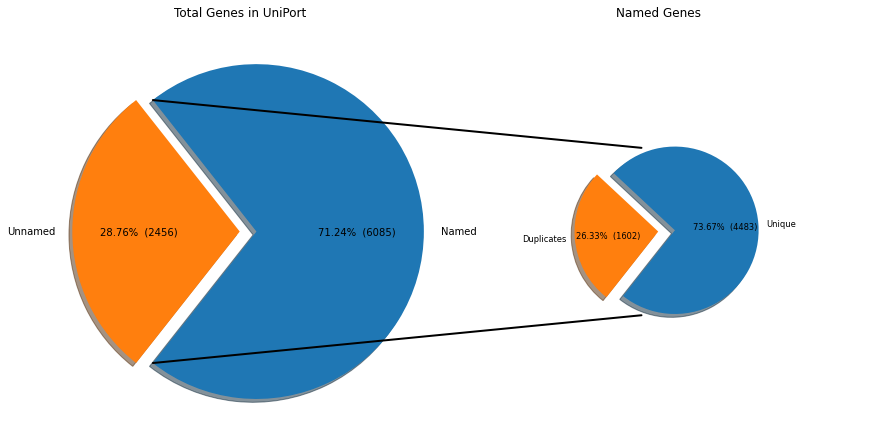

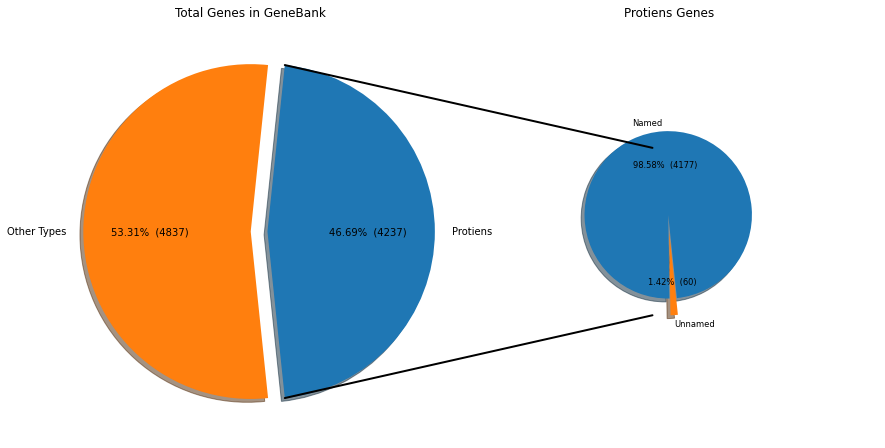

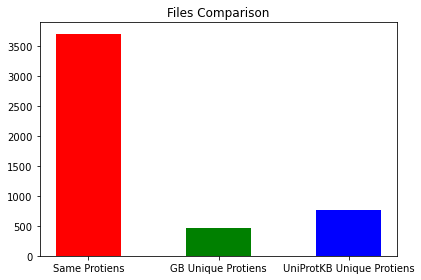

In [10]:
# plot some data:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def plot_gene_pie(_data, _labels,_titles,_exp,_angle,_width):

        fig = plt.figure(figsize=(15,10))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        fig.subplots_adjust(wspace=0)

        # large pie chart parameters
        ax1.pie(_data[0], autopct=make_autopct(_data[0]), startangle=_angle,
                labels=_labels[0], explode=_exp, shadow=True)

        # small pie chart parameters
        ax2.pie(_data[1], autopct=make_autopct(_data[1]), startangle=_angle,textprops={'size': 'smaller'},
                labels=_labels[1], radius=0.5, shadow=True, explode=_exp)

        ax1.set_title(_titles[0])
        ax2.set_title(_titles[1])

        # use ConnectionPatch to draw lines between the two plots
        # get the wedge data
        theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
        center, r = ax1.patches[0].center, ax1.patches[0].r

        # draw top connecting line
        x = r * np.cos(np.pi / 180 * theta2) + center[0]
        y = np.sin(np.pi / 180 * theta2) + center[1]
        con = ConnectionPatch(xyA=(- _width / 2, .5), xyB=(x, y),
                        coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
        con.set_color([0, 0, 0])
        con.set_linewidth(2)
        ax2.add_artist(con)

        # draw bottom connecting line
        x = r * np.cos(np.pi / 180 * theta1) + center[0]
        y = np.sin(np.pi / 180 * theta1) + center[1]
        con = ConnectionPatch(xyA=(- _width / 2, -.5), xyB=(x, y), coordsA="data",
                        coordsB="data", axesA=ax2, axesB=ax1)
        con.set_color([0, 0, 0])
        ax2.add_artist(con)
        con.set_linewidth(2)

        plt.show()

#show UniProtKB file data:
uni_file_count = len(prot_names)
total_uni_file = uni_file_count + uni_null_count
uni_file_dup = uni_file_count-count_unique

uni_chart = [[uni_file_count, uni_null_count],[count_unique, uni_file_dup]]
labels = [['Named', 'Unnamed'],['Unique', 'Duplicates']]
titles= ['Total Genes in UniPort','Named Genes']
explode = [0.1, 0]
angle = -180 * (uni_file_count/total_uni_file)
width = .2

plot_gene_pie(uni_chart, labels, titles, explode, angle, width)

#show GeneBank file details

total_named_prot_gb = len(features_prot)
total_unprot_gb = len(features)- total_gb_prot
total_gb = total_gb_prot + total_unprot_gb
gb_chart = [[total_gb_prot, total_unprot_gb],[total_named_prot_gb, gb_null_counter]]
labels = [['Protiens', 'Other Types'],['Named', 'Unnamed']]
titles= ['Total Genes in GeneBank','Protiens Genes']
explode = [0.1, 0]
angle = -180 * (total_gb_prot/total_gb)
width = .2

plot_gene_pie(gb_chart, labels, titles, explode, angle, width)

compare_chart = [len(same_prot), len(gb_only), len(uni_only)]
_labels = ['Same Protiens', 'GB Unique Protiens', 'UniProtKB Unique Protiens']
plt.bar(_labels, compare_chart, color= ['r','g','b'], width=0.5)
plt.title('Files Comparison')
plt.tight_layout()
plt.show()


question B

In [11]:
table = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
    }

Hidrophobic = ('A','F','L','I','M','P','W')   
Hidrophilic = ('G','S','Y','Q','K','D','T','C','N','R','H','E')   


In [12]:
import regex as re

trans_len = []
hidro_prec = []


# count occuarnce of substrings from list in sequance
def count_occ_in_seq(seq,occ):
    c = sum(map(lambda x: x in occ, seq))
    return c/len(seq)*100

def count_hidro(seq):
    hidro_prec.append(count_occ_in_seq(seq,Hidrophobic))
    
def find_all_pos(pos,seq):
    r1 = re.findall(r'\d*[0-9]\.\.\d*[0-9]',pos) ## find all coords of the seq
    res = []
    for r in r1:
        first, second = re.split(r'\.\.',r) ## split the coord and get the seq
        # first +=0 if first == 0 else first -= 1 
        trans_seq = seq[int(first):int(second)+1]
        count_hidro(trans_seq)
        res.append(trans_seq)
        trans_len.append(len(trans_seq)) 

    return res


trans_df = df[df['Transmembrane'].notna()]
trans_df['Transmembrane Sequences'] = trans_df.apply(lambda x: find_all_pos(x.Transmembrane,x.Sequence), axis=1)

# trans_df.head()
# trans_s = trans_df['Transmembrane']
# trans_s[0]
# trans_df['Sequence']

C:\Users\97250\AppData\Local\Temp/ipykernel_30900/3623087022.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_df['Transmembrane Sequences'] = trans_df.apply(lambda x: find_all_pos(x.Transmembrane,x.Sequence), axis=1)


In [13]:
print(trans_df['Transmembrane Sequences'][0])
print([trans_df['Transmembrane'][0]])
print([trans_df['Sequence'][0]])
print(len(trans_len))
# print(len(trans_len))

['AAVFSITIPIISAILIINFFT', 'PVFFPLLLSPIGIILAFVSIK', 'VLNAIMFPFPFFWFIGGALLF']
['TRANSMEM 6..26;  /note="Helical";  /evidence="ECO:0000255"; TRANSMEM 37..57;  /note="Helical";  /evidence="ECO:0000255"; TRANSMEM 68..88;  /note="Helical";  /evidence="ECO:0000255"']
['MNVKKAAAVFSITIPIISAILIINFFTGFMSIPWQGMPVFFPLLLSPIGIILAFVSIKTNKRCAVYGIVLNAIMFPFPFFWFIGGALLFGV']
10668


11 44 21.391638545181852 57.99348052291291 71.42857142857143


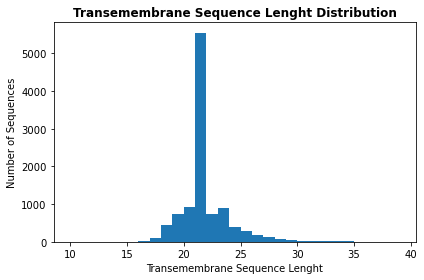

In [23]:
tran_min_len = min(trans_len)
tran_max_len = max(trans_len)
tran_avg_len = np.average(trans_len)
hidro_avg_perc = np.average(hidro_prec)

print(tran_min_len, tran_max_len, tran_avg_len,hidro_avg_perc, hidro_prec[0])
plt.hist(np.array(trans_len),bins=range(10,40),)
plt.xlabel('Transemembrane Sequence Lenght')
plt.ylabel('Number of Sequences') 
plt.title('Transemembrane Sequence Lenght Distribution',
          fontweight ="bold")
plt.tight_layout()
plt.show()


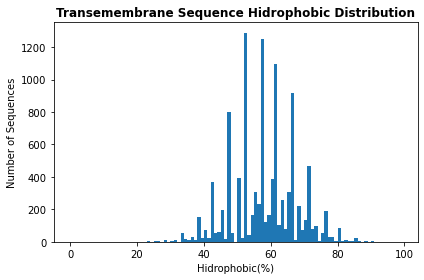

In [24]:
plt.hist(hidro_prec, range(100))
plt.xlabel('Hidrophobic(%)')
plt.ylabel('Number of Sequences') 
plt.title('Transemembrane Sequence Hidrophobic Distribution',
          fontweight ="bold")
plt.tight_layout()
plt.show()

סביבתה הפנימית של הממבנה היא הידרופובית, והחלבונים הטרנס-ממברנליים עוברים דרכה ולכן הצפייה היא שהרצפים המרכיבים את החלבונים הללו יהיו הידרופוביים או בעלי אחוז גבוה של חומצות אמינו הידרופוביות. זה מתאים לתוצאה שרואים בהיסטוגרמה 

In [16]:
df_B = trans_df[trans_df['Gene names  (primary )'].isin(list(same_prot))]
df_B.head()

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Transmembrane,Sequence,Gene names (primary ),Transmembrane Sequences
0,P94485,YNAG_BACSU,reviewed,Uncharacterized protein YnaG,ynaG BSU17550,Bacillus subtilis (strain 168),91.0,"TRANSMEM 6..26; /note=""Helical""; /evidence=""...",MNVKKAAAVFSITIPIISAILIINFFTGFMSIPWQGMPVFFPLLLS...,ynaG,"[AAVFSITIPIISAILIINFFT, PVFFPLLLSPIGIILAFVSIK,..."
3,O34460,YTRI_BACSU,reviewed,Sporulation membrane protein YtrI,ytrI BSU29240,Bacillus subtilis (strain 168),167.0,"TRANSMEM 15..35; /note=""Helical""; /evidence=...",MRVPQHYKKPGWQRFFAGMMCGAVISWFFFLFTYGTFQEEQVSLIE...,ytrI,[FAGMMCGAVISWFFFLFTYGT]
6,O32050,YRBG_BACSU,reviewed,UPF0702 transmembrane protein YrbG,yrbG BSU27680,Bacillus subtilis (strain 168),218.0,"TRANSMEM 4..24; /note=""Helical""; /evidence=""...",MEELLTIAFRTVVLYFVILVIFRFMGKREIGELSILDLVVFIMMAE...,yrbG,"[LTIAFRTVVLYFVILVIFRFM, LSILDLVVFIMMAEIAVLAIE,..."
11,O32111,YUZG_BACSU,reviewed,Uncharacterized protein YuzG,yuzG BSU32120,Bacillus subtilis (strain 168),46.0,"TRANSMEM 20..42; /note=""Helical""; /evidence=...",MAQNEEKTPKSQKIQDRIIMAMIWVVAALVIALVVGTALNYINIFK,yuzG,[AMIWVVAALVIALVVGTALNYIN]
12,O31793,YMAG_BACSU,reviewed,Uncharacterized protein YmaG,ymaG BSU17310,Bacillus subtilis (strain 168),91.0,"TRANSMEM 50..70; /note=""Helical""; /evidence=...",MNELEHFSPEDTRIFGRPFGFGRPFGFGRPFGFGYGFGRPGFGYGF...,ymaG,[GFFGGPFIGGLAGGLIGSALF]


In [17]:
df_B.keys()

Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Transmembrane', 'Sequence',
       'Gene names  (primary )', 'Transmembrane Sequences'],
      dtype='object')

In [18]:
df_B['GC%'] = df_B.apply(lambda x: count_occ_in_seq(x['Sequence'], ['G','C']), axis=1)

C:\Users\97250\AppData\Local\Temp/ipykernel_30900/2683943353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_B['GC%'] = df_B.apply(lambda x: count_occ_in_seq(x['Sequence'], ['G','C']), axis=1)


In [19]:
df_B.head()

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Transmembrane,Sequence,Gene names (primary ),Transmembrane Sequences,GC%
0,P94485,YNAG_BACSU,reviewed,Uncharacterized protein YnaG,ynaG BSU17550,Bacillus subtilis (strain 168),91.0,"TRANSMEM 6..26; /note=""Helical""; /evidence=""...",MNVKKAAAVFSITIPIISAILIINFFTGFMSIPWQGMPVFFPLLLS...,ynaG,"[AAVFSITIPIISAILIINFFT, PVFFPLLLSPIGIILAFVSIK,...",8.791209
3,O34460,YTRI_BACSU,reviewed,Sporulation membrane protein YtrI,ytrI BSU29240,Bacillus subtilis (strain 168),167.0,"TRANSMEM 15..35; /note=""Helical""; /evidence=...",MRVPQHYKKPGWQRFFAGMMCGAVISWFFFLFTYGTFQEEQVSLIE...,ytrI,[FAGMMCGAVISWFFFLFTYGT],3.592814
6,O32050,YRBG_BACSU,reviewed,UPF0702 transmembrane protein YrbG,yrbG BSU27680,Bacillus subtilis (strain 168),218.0,"TRANSMEM 4..24; /note=""Helical""; /evidence=""...",MEELLTIAFRTVVLYFVILVIFRFMGKREIGELSILDLVVFIMMAE...,yrbG,"[LTIAFRTVVLYFVILVIFRFM, LSILDLVVFIMMAEIAVLAIE,...",5.045872
11,O32111,YUZG_BACSU,reviewed,Uncharacterized protein YuzG,yuzG BSU32120,Bacillus subtilis (strain 168),46.0,"TRANSMEM 20..42; /note=""Helical""; /evidence=...",MAQNEEKTPKSQKIQDRIIMAMIWVVAALVIALVVGTALNYINIFK,yuzG,[AMIWVVAALVIALVVGTALNYIN],2.173913
12,O31793,YMAG_BACSU,reviewed,Uncharacterized protein YmaG,ymaG BSU17310,Bacillus subtilis (strain 168),91.0,"TRANSMEM 50..70; /note=""Helical""; /evidence=...",MNELEHFSPEDTRIFGRPFGFGRPFGFGRPFGFGYGFGRPGFGYGF...,ymaG,[GFFGGPFIGGLAGGLIGSALF],25.274725


In [20]:
B_GC = list(df_B['GC%'])

B_max_GC, B_min_GC, B_mean_GC, B_avg_GC = max(B_GC), min(B_GC), np.median(B_GC), np.average(B_GC)

print(B_max_GC, B_min_GC, B_mean_GC, B_avg_GC)

42.30769230769231 0.0 8.011869436201781 8.161366675991502
